![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [89]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [90]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [91]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [92]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [93]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

Рассмотрим стобец City

In [95]:
#Сделаем "нормализацию" значения рейтинга по городам
means = data.groupby('City')['Ranking'].mean()
std = data.groupby('City')['Ranking'].std()
data['Ranking_std'] = (data.Ranking - data.City.map(means))/(data.City.map(std))

In [96]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',])

Возьмем следующий признак "Cuisine Style".

In [97]:
# заменим нулевые значения на no_cuisine
data['Cuisine Style'] = data['Cuisine Style'].fillna('no_cuisine')

In [98]:
# приведем значения в столбце к необходимому формату
data['Cuisine Style'] = data['Cuisine Style'].astype (str)

def fix_cuisine_style(x):
    x = x.replace('[', '')
    x = x.replace(']', '')
    x = x.replace("'", '')
    return x.split(', ')


data['Cuisine Style'] = data['Cuisine Style'].apply(fix_cuisine_style)

In [99]:
#присоеденим полученный датафрейм к исходному
data_cuisines = pd.get_dummies(data['Cuisine Style'].apply(pd.Series).stack()).sum(level=0)
data = pd.merge(data, data_cuisines, left_index=True, right_index=True)

#### Возьмем следующий признак "Price Range".

In [100]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [101]:
# Ваша обработка 'Price Range'
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')
price_dict = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price Range'] = data['Price Range'].map(lambda x: price_dict.get(x,x))

Возьмем следующий признак "Number of Reviews".

In [102]:
#заменим пропуски средним значением
data['Number of Reviews'] = data['Number of Reviews'].fillna(data['Number of Reviews'].mean())

Возьмем следующий признак "Reviews".

In [103]:
# анализируем столбец
data['Reviews']

0                                                 [[], []]
1        [['Very good reviews!', 'Fine dining in Hakani...
2        [['Better than the Links', 'Ivy Black'], ['12/...
3        [['Most exquisite', 'Delicious and authentic']...
4        [['Always the best in bratislava', 'Very good ...
                               ...                        
49995    [['The real Italian experience!', 'Wonderful f...
49996    [['Parisian atmosphere', 'Bit pricey but inter...
49997    [['Good by swedish standards', 'A hidden jewel...
49998    [['Underground restaurant', 'Oldest Restaurant...
49999    [['Average', 'Nice an informal'], ['01/31/2016...
Name: Reviews, Length: 50000, dtype: object

In [104]:
#заменяем нулевые значения
data['Reviews'] = data['Reviews'].fillna('[[], []]')

In [105]:
#необходимо вытащить даты ближайших отзывов и создать новый признак с разницой в днях между отзывами
def fix_Reviews(x):
    if x == '[[], []]':
        return []
    else:
        x = x.replace(']]', '')
        x = x.replace("'", '')
        x = x.split('], [')[1]
        x = x.split(', ')
        return x


data['Dates of Reviews'] = data['Reviews'].apply(fix_Reviews)
data[['Date_1', 'Date_2']] = pd.DataFrame(data['Dates of Reviews'].tolist())
data['Date_1'] = pd.to_datetime(data['Date_1']).dt.date
data['Date_2'] = pd.to_datetime(data['Date_2']).dt.date
data['Timedelta'] = data['Date_1'] - data['Date_2']

In [106]:
#заменим нулевые значения на среднее и преобразуем формат
data['Timedelta'] = data['Timedelta'].fillna(data['Timedelta'].mean())
data['Timedelta'] = data['Timedelta'].dt.days.astype('int32')

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

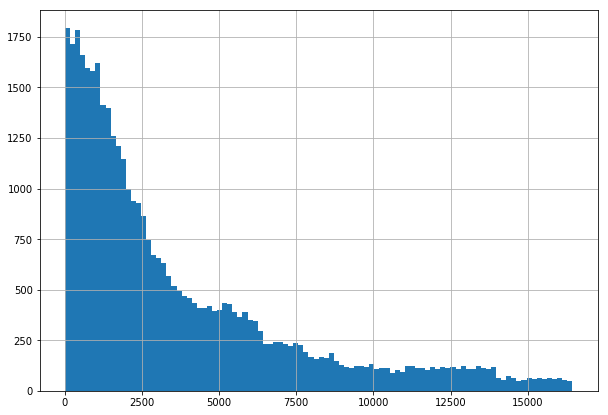

In [107]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

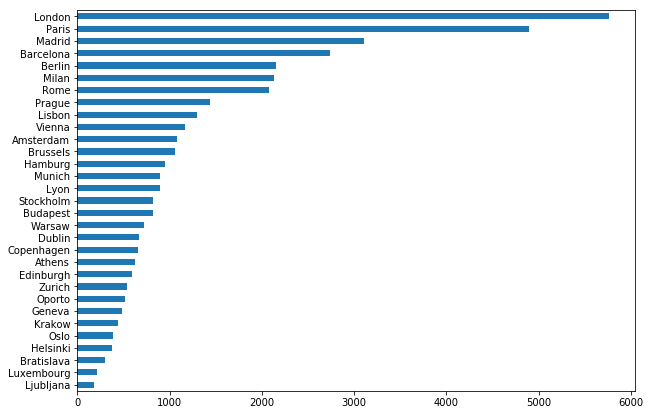

In [108]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

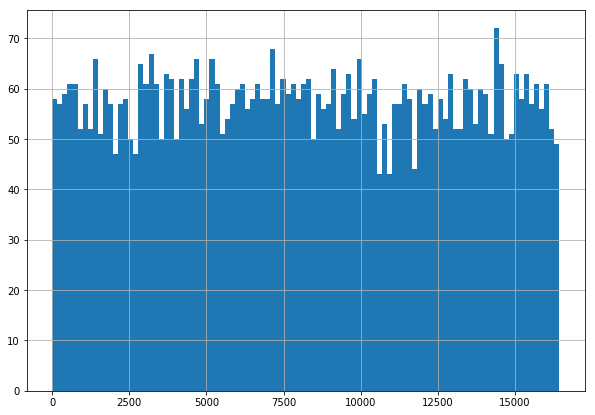

In [109]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

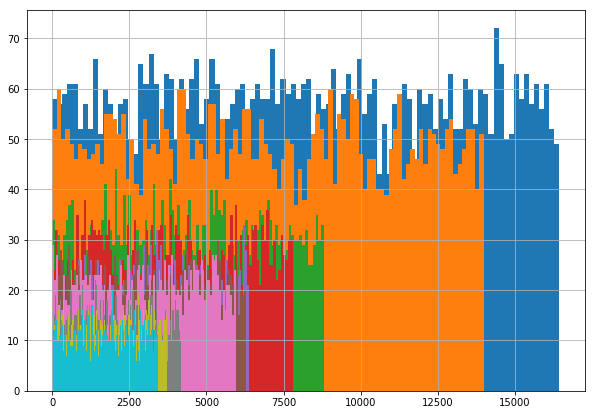

In [110]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

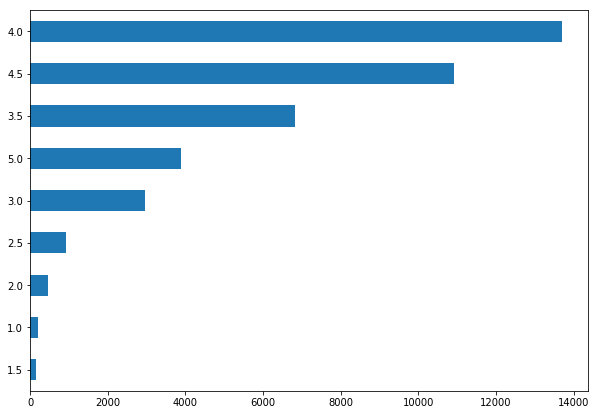

In [111]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

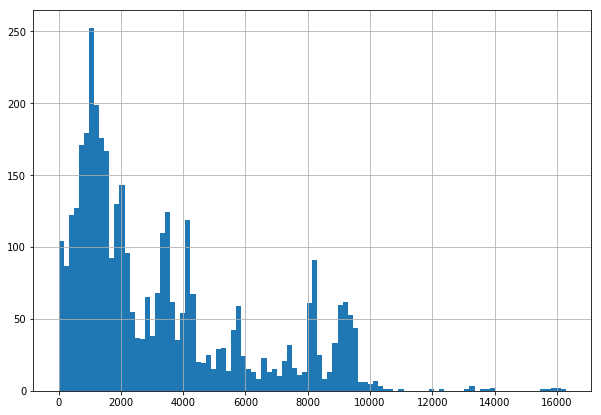

In [112]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

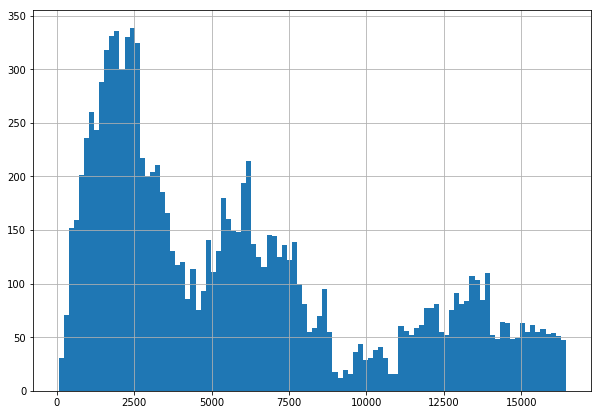

In [113]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

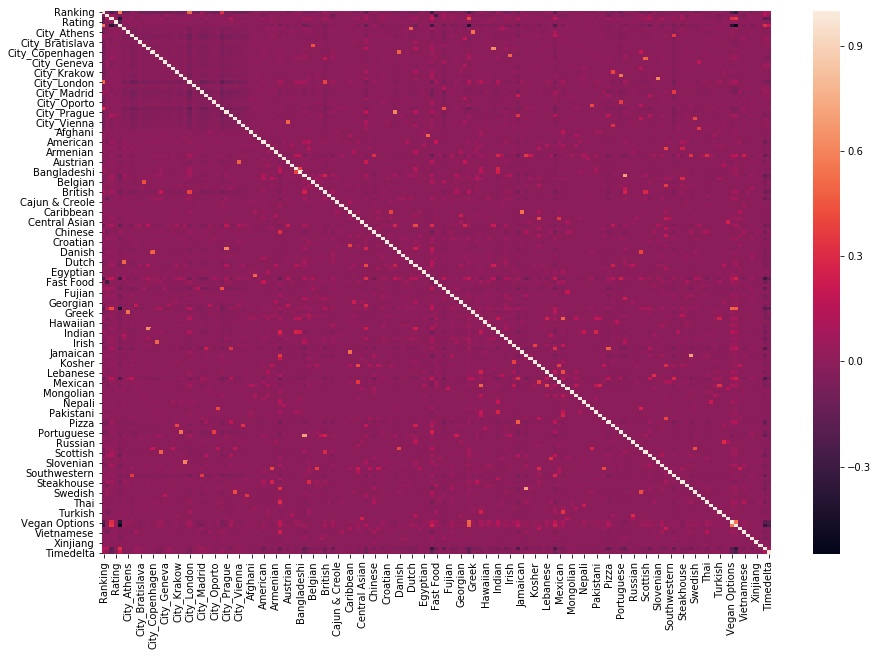

In [114]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [115]:
data = data.drop(['Restaurant_id', 'Cuisine Style', 'Reviews',
                  'URL_TA', 'ID_TA', 'Dates of Reviews', 'Date_1', 'Date_2'], axis=1)

In [116]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [117]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [118]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 163), (40000, 163), (40000, 162), (32000, 162), (8000, 162))

# Model 
Сам ML

In [119]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [120]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [121]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [122]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20416312499999997


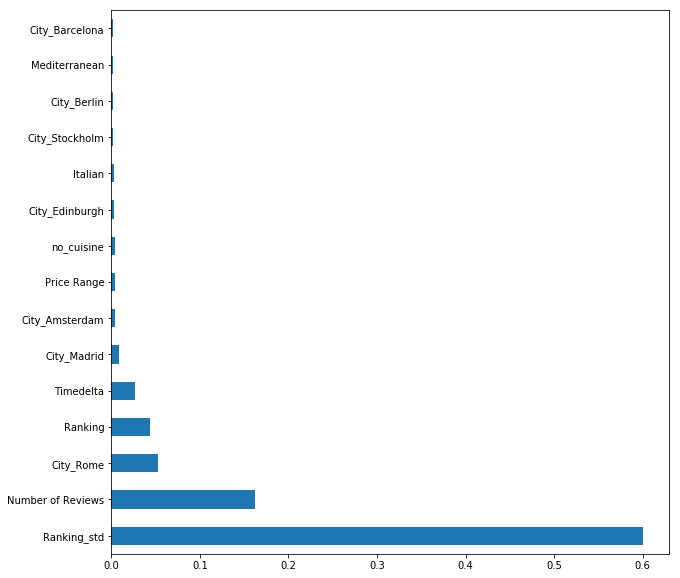

In [123]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [124]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Ranking_std,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,no_cuisine,Timedelta
5959,888.0,1,21.000000,0.0,0.005579,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,24
8453,688.0,2,34.000000,0.0,-0.513720,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,23
1405,13137.0,2,3.000000,0.0,1.534294,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,124
6190,5167.0,2,124.471197,0.0,1.052290,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,124
5598,3509.0,2,4.000000,0.0,-0.163562,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-73
6877,776.0,2,113.000000,0.0,-1.091902,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,91
7285,1951.0,2,35.000000,0.0,0.725852,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3088
4965,5575.0,2,50.000000,0.0,0.748692,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,330
2792,5921.0,2,3.000000,0.0,0.901470,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,17
4153,10456.0,2,8.000000,0.0,0.870669,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,124


In [125]:
test_data = test_data.drop(['Rating'], axis=1)

In [126]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [127]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [128]:
predict_submission

array([3.06 , 4.32 , 4.45 , ..., 3.095, 4.49 , 4.185])

In [129]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.060
1,id_1,4.320
2,id_2,4.450
3,id_3,4.320
4,id_4,4.475
5,id_5,4.405
6,id_6,1.685
7,id_7,2.650
8,id_8,4.255
9,id_9,4.740


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
